In [1]:
# In[1]:


from __future__ import print_function, division, absolute_import
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import rc

#plt.style.use('dark_background')
rc('font', size=15)
rc('legend', fontsize=10)
rc('xtick', labelsize=12)

fig_size = (12, 5)

def perturb_fit(x, a, b,):
     return -a/np.sqrt(np.sqrt(pow(pow(x*pow(10,-10),2)-b,2)))

In [3]:
# In[3]:


from skreflectometry.mode_O import refraction_index_O, refractive_matrix_O, cutoff_freq_O

from skreflectometry.data_generation import density_profile, density_add_timed_gaussian, find_nearest_index
from skreflectometry.reflectometry_sim import phase_delay

from scipy.optimize import curve_fit
from scipy.constants import elementary_charge, electron_mass, epsilon_0, \
    speed_of_light


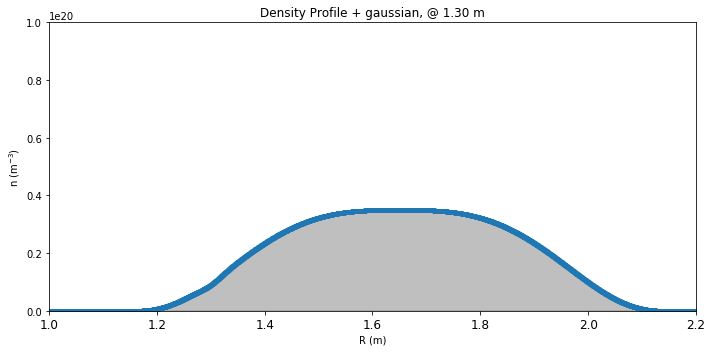

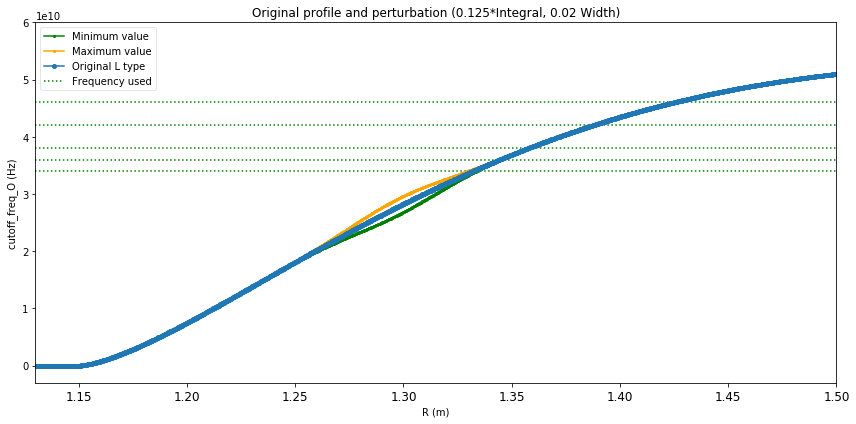

In [4]:
# In[3]:

plt.figure(figsize=(10, 5))
npoints=5000


g_width=0.02
g_pos=1.3
g_integral=0.125
tmax=4.
osc_period=tmax


#H-mode
#radius_arr, dens_prof = density_profile(dens_central=6.5e19, r_lfs=2.2, m=15, n=5, n_points=npoints)

#L-mode
radius_arr, dens_prof = density_profile(dens_central=3.5e19, m=3, n=3, n_points=npoints)

#Add a gaussian bump with a g_integral fraction of the base profile integral from center-width to center+width
g_h= np.trapz(dens_prof[find_nearest_index(radius_arr, g_pos-g_width):find_nearest_index(radius_arr, g_pos+g_width)],radius_arr[find_nearest_index(radius_arr, g_pos-g_width):find_nearest_index(radius_arr, g_pos+g_width)],dx=0.0001)

dens_prof_test= density_add_timed_gaussian(radius_arr, dens_prof, n_points=npoints, gauss_integral=g_integral*g_h, gauss_width=g_width, gauss_pos=g_pos, gauss_t=3., oscillation_period=osc_period)

###
#Plot the base profile chosen - bump
ax1 = plt.gca()
rs, ns = radius_arr, dens_prof_test
plt.plot(rs, ns, '-o', markersize=4)
plt.fill_between(rs, ns, 0.0, color='k', alpha=0.25)

plt.xlabel('R (m)')
plt.ylabel('n (m$^{-3}$)')
plt.title('Density Profile + gaussian, @ %.2f m' %g_pos)

#plt.xlim(0, 0.05)
plt.xlim(1.0, 2.2)
plt.ylim(0, 1.0e20)


plt.tight_layout()
plt.savefig('images/density_profiles.png', dpi=200)
plt.show()

#Plot profile in terms of cutoff frequency and decide frequencies that will be used 
cutoff_arr = np.zeros(radius_arr.shape)

r_central=2.3
hfs_inds = radius_arr <= r_central

plt.figure(figsize=(12, 6))

cutoff_arr[hfs_inds]= cutoff_freq_O(dens_prof_test[hfs_inds])
plt.plot(rs, cutoff_arr, '-o', markersize=2, color= 'green', label='Minimum value')

dens_prof_test= density_add_timed_gaussian(radius_arr, dens_prof, n_points=npoints, gauss_integral=g_integral*g_h, gauss_width=g_width, gauss_pos=g_pos, gauss_t=1., oscillation_period=osc_period)
cutoff_arr[hfs_inds]= cutoff_freq_O(dens_prof_test[hfs_inds])
plt.plot(rs, cutoff_arr, '-o', markersize=2, color= 'orange', label='Maximum value')

cutoff_arr[hfs_inds]= cutoff_freq_O(dens_prof[hfs_inds])
plt.plot(rs, cutoff_arr, '-o', markersize=4, label='Original L type')

#pick 5 reflectometer frequencies 
f_reflect=[34e9,36e9,38e9,42e9,46e9]
plt.hlines(f_reflect, xmin=1.13, xmax=1.5, colors='green', linestyles=':', label='Frequency used')


plt.xlabel('R (m)')
plt.ylabel('cutoff_freq_O (Hz)')
plt.title('Original profile and perturbation (%.3f*Integral, %.2f Width)' %(g_integral,g_width))

legend_loc='best'
plt.legend(loc=legend_loc, framealpha=.5, facecolor='white')

plt.xlim(1.13, 1.5)
plt.ylim(-0.3e10, 6e10)
plt.tight_layout()

plt.savefig('images/cutoff.png', dpi=200)
plt.show()


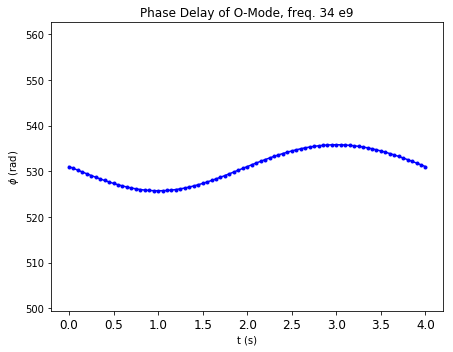

In [5]:
# In[4]:

sweep_time = 1
n_points_fs= int(1)

### See how the phase delay changes over time for a specific frequency f_sampling
# using default functions for phase delay numerical calculations 

f_sampling = f_reflect[0]
fs_O = np.array([f_sampling])

i=0.
dt=0.05

n_index_O=np.zeros(round(tmax/dt))
n_index_O_sq=np.zeros(round(tmax/dt))
t=np.linspace(0., tmax, round(tmax/dt+1))

n_index_O=np.ndarray(shape=(round(tmax/dt+1),npoints))
phi_O=np.zeros(t.shape)

while i<tmax:
    iterated_dens= np.array([density_add_timed_gaussian(radius_arr, dens_prof, n_points=npoints, gauss_integral=g_integral*g_h, gauss_width=g_width, gauss_pos=g_pos, gauss_t=i, oscillation_period=osc_period)])
    n_index_O[round(i/dt)] = refractive_matrix_O(iterated_dens, fs_O)
    phi_O[round(i/dt)] = phase_delay(fs_O, radius_arr, n_index_O[[round(i/dt)]], reflect_at_wall=True)
    i+=dt

       
plt.figure(figsize=fig_size)

plt.subplot(1, 2, 1)

plt.plot(t, phi_O, 'b.-')

f_sampling_title=f_sampling/1e9
plt.title('Phase Delay of O-Mode, freq. %.0f e9' %f_sampling_title)
plt.xlabel('t (s)')
plt.ylabel('$\phi$ (rad)')
plt.ylim(0.95*phi_O[round(tmax/(4.*dt))],1.05*phi_O[round(3.*tmax/(4.*dt))])

plt.tight_layout()
plt.savefig('images/phase_delays.png', dpi=200)
plt.show()



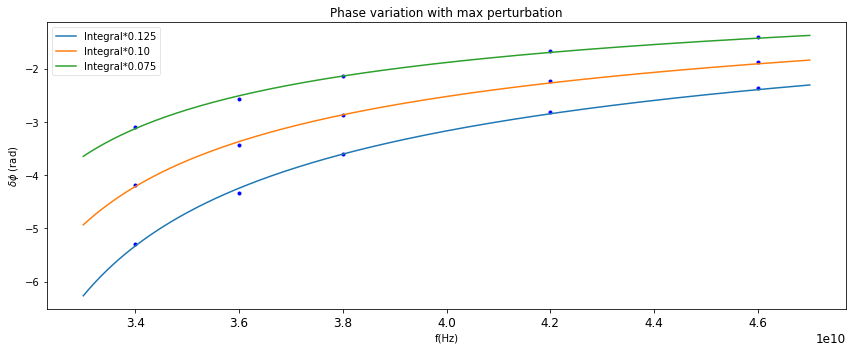

In [6]:

# In[5]:
#Select a specific time, in this example @max positive perturbation, and run reflectometers for the selected frequencies

f_array=[np.array([f_reflect[0]]),np.array([f_reflect[1]]),np.array([f_reflect[2]]),np.array([f_reflect[3]]),np.array([f_reflect[4]])]
i=0
perturb_dens125= np.array([density_add_timed_gaussian(radius_arr, dens_prof, n_points=npoints, gauss_integral=g_integral*g_h, gauss_width=g_width, gauss_pos=g_pos, gauss_t=osc_period/4., oscillation_period=osc_period)])
phi_diff125=np.zeros(5)

g_integral=0.10
perturb_dens10= np.array([density_add_timed_gaussian(radius_arr, dens_prof, n_points=npoints, gauss_integral=g_integral*g_h, gauss_width=g_width, gauss_pos=g_pos, gauss_t=osc_period/4., oscillation_period=osc_period)])
phi_diff10=np.zeros(5)

g_integral=0.075
perturb_dens75= np.array([density_add_timed_gaussian(radius_arr, dens_prof, n_points=npoints, gauss_integral=g_integral*g_h, gauss_width=g_width, gauss_pos=g_pos, gauss_t=osc_period/4., oscillation_period=osc_period)])
phi_diff75=np.zeros(5)

while i<5:
    n_index_O = refractive_matrix_O(perturb_dens125, f_array[i])
    phi_O = phase_delay(f_array[i], radius_arr, n_index_O, reflect_at_wall=True)
    phi_diff125[i]=phi_O-phase_delay(f_array[i], radius_arr, refractive_matrix_O(dens_prof, f_array[i]), reflect_at_wall=True)
    
    n_index_O = refractive_matrix_O(perturb_dens10, f_array[i])
    phi_O = phase_delay(f_array[i], radius_arr, n_index_O, reflect_at_wall=True)
    phi_diff10[i]=phi_O-phase_delay(f_array[i], radius_arr, refractive_matrix_O(dens_prof, f_array[i]), reflect_at_wall=True)
    
    n_index_O = refractive_matrix_O(perturb_dens75, f_array[i])
    phi_O = phase_delay(f_array[i], radius_arr, n_index_O, reflect_at_wall=True)
    phi_diff75[i]=phi_O-phase_delay(f_array[i], radius_arr, refractive_matrix_O(dens_prof, f_array[i]), reflect_at_wall=True)
    
    i+=1

#Fit the phase delay points with derived expression

popt125, pcov125 = curve_fit(perturb_fit,f_reflect,phi_diff125,bounds=(0, [50., 15.]))
#fit assuming perturbation peak with less than 15% of density value and perturbation integral positive
perr125 = np.sqrt(np.diag(pcov125))

popt10, pcov10 = curve_fit(perturb_fit,f_reflect,phi_diff10,bounds=(0, [50., 15.]))
perr10 = np.sqrt(np.diag(pcov10))

popt75, pcov75 = curve_fit(perturb_fit,f_reflect,phi_diff75,bounds=(0, [50., 15.]))
perr75 = np.sqrt(np.diag(pcov75))


def h(b,opt):
    l = []
    for i in b:
        if opt==125:
            l.append(float(perturb_fit(i,popt125[0],popt125[1])))
        if opt==10:
            l.append(float(perturb_fit(i,popt10[0],popt10[1])))
        if opt==75:
            l.append(float(perturb_fit(i,popt75[0],popt75[1])))
    return l

plt.figure(figsize=fig_size)

#Plot the fitted curves and phase delay point. Repeated for 3 different perturbations, can vary the parameters
plt.plot(f_reflect, phi_diff125, 'b.')
f_array=np.linspace(33e9, 47e9, 500)
plt.plot(f_array, h(f_array,125), label='Integral*0.125')

plt.plot(f_reflect, phi_diff10, 'b.')
plt.plot(f_array, h(f_array,10), label='Integral*0.10')

plt.plot(f_reflect, phi_diff75, 'b.')
plt.plot(f_array, h(f_array,75), label='Integral*0.075')

legend_loc='best'
plt.legend(loc=legend_loc, framealpha=.5, facecolor='white')

plt.title('Phase variation with max perturbation')
plt.xlabel('f(Hz)')
plt.ylabel('$\delta\phi$ (rad)')
plt.tight_layout()
plt.show()


In [7]:

# In[9]:
#Compare the fitted parameters with the actual known parameters of the perturbations 
integral_factor=pow(elementary_charge,2)*pow(10,-10)/(speed_of_light*epsilon_0*electron_mass*2*math.pi)

integral_fitted=[popt125[0]/(g_h*integral_factor),popt10[0]/(g_h*integral_factor),popt75[0]/(g_h*integral_factor)]
integral_fitted_error=[perr125[0]/(g_h*integral_factor),perr10[0]/(g_h*integral_factor),perr75[0]/(g_h*integral_factor)]
expected_int=[0.125,0.10,0.075]
sigma_shift_int=[(expected_int[0]-integral_fitted[0])/expected_int[0],(expected_int[1]-integral_fitted[1])/expected_int[1],(expected_int[2]-integral_fitted[2])/expected_int[2]]

print("integral")
print(integral_fitted)
print(expected_int)
print(sigma_shift_int)

expected=dens_prof[find_nearest_index(radius_arr,g_pos)]

print("freq")
cutoff_fitted=[np.sqrt(popt125[1]),np.sqrt(popt10[1]),np.sqrt(popt75[1])]
cutoff_expected=[cutoff_freq_O(expected)*pow(10,-10),cutoff_freq_O(expected)*pow(10,-10),cutoff_freq_O(expected)*pow(10,-10)]
sigma_shift_f=[(cutoff_expected[0]-cutoff_fitted[0])/cutoff_expected[0],(cutoff_expected[1]-cutoff_fitted[1])/cutoff_expected[1],(cutoff_expected[2]-cutoff_fitted[2])/cutoff_expected[2]]

print(cutoff_fitted)
print(cutoff_expected)
print(sigma_shift_f)

integral
[0.12415350547738312, 0.09926123879625275, 0.07443088161806502]
[0.125, 0.1, 0.075]
[0.006771956180935068, 0.007387612037472596, 0.007588245092466361]
freq
[3.021764322761038, 3.0128188376704226, 3.004151367666768]
[2.8308522290212994, 2.8308522290212994, 2.8308522290212994]
[-0.06743979490788962, -0.0642797977173234, -0.06121800949863873]
